In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter


In [2]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [3]:
# dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
#            "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
#            "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
#            "soil" : pd.read_csv("../src/soil_data.csv"),
#            }

In [4]:
# dataDic["train"].columns

In [5]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [6]:
# dfs = {
#     k: dataDic[k].set_index(['fips', 'date'])
#     for k in dataDic.keys() if k != "soil"
# }

# dfs["soil"] = dataDic["soil"]

In [7]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 9e-5
epochs = 15
clip = 5


In [8]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [9]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [10]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [11]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [12]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train")
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)

In [13]:
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True)
# print("test shape", X_time_test.shape)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [14]:
# import pickle
# # export all
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)


In [15]:
import pickle
# import all
X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
    valid_fips = pickle.load(f)
with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
    test_fips = pickle.load(f)

In [16]:
y_train_tensor = torch.tensor(y_target_train[:, :output_weeks])

# Flatten the target tensor to compute class frequencies
flat_labels = y_train_tensor.view(-1).numpy().round().astype(int)  # Shape: [observations * weeks]
class_counts = np.bincount(flat_labels)  # Count occurrences of each class
class_weights = 1.0 / class_counts       # Inverse of class frequencies

# Map class weights to each [i, j] in the target tensor
weights_per_sample = class_weights[y_train_tensor.numpy().round().astype(int)]  # Shape: [observations, weeks]

# Compute the average weight per observation (averaging over the 6 weeks)
sample_weights = weights_per_sample.mean(axis=1)  # Shape: [observations]

# Create a sampler for the training data
train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

# Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    y_train_tensor,
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [33]:
test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [17]:
len(train_loader)

808

In [18]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(num_numerical_features, num_numerical_features))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(num_numerical_features, num_numerical_features)
        )

        # TS branch
        self.lstm = nn.LSTM(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )

        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = num_numerical_features + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)
        numerical_data = numerical_data.to(torch.float32)
        time_series_data = time_series_data.to(torch.float32)
        x1 = self.tabular_fc_layers(numerical_data)
        # Pass the time series data through the LSTM
        lstm_out, _ = self.lstm(time_series_data, (h0, c0))
        # Pass the data through the attention mechanism
        context_vector = lstm_out[:, -1, :]  # Last time step output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [19]:
writer = SummaryWriter('../runs/LSTM_0_each_batch')

In [20]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.HuberLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)

for i in range(epochs):
    for k, (inputs, static, labels) in tqdm(enumerate(train_loader),
                                            desc=f"epoch {i+1}/{epochs}",
                                            total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        output = model(inputs, static)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    out = model(inp, stat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(Hubber)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/simple_lstm.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/15:  50%|█████     | 404/808 [02:27<26:55,  4.00s/it]

{'loss': 0.39488935470581055, 'epoch': 0.5, 'step': 404, 'lr': 6.206697825411565e-06, 'week': 1, 'validation_loss': np.float64(0.34485559100690094), 'macro_f1': np.float64(0.13287963153914897), 'micro_f1': np.float64(0.6628943758573388), 'mae': np.float64(0.6002357602860212)}
{'loss': 0.39488935470581055, 'epoch': 0.5, 'step': 404, 'lr': 6.206697825411565e-06, 'week': 2, 'validation_loss': np.float64(0.34485559100690094), 'macro_f1': np.float64(0.13275553721282157), 'micro_f1': np.float64(0.6618655692729767), 'mae': np.float64(0.6024083724506326)}
{'loss': 0.39488935470581055, 'epoch': 0.5, 'step': 404, 'lr': 6.206697825411565e-06, 'week': 3, 'validation_loss': np.float64(0.34485559100690094), 'macro_f1': np.float64(0.13722070030306488), 'micro_f1': np.float64(0.6512345679012346), 'mae': np.float64(0.6309112842559297)}
{'loss': 0.39488935470581055, 'epoch': 0.5, 'step': 404, 'lr': 6.206697825411565e-06, 'week': 4, 'validation_loss': np.float64(0.34485559100690094), 'macro_f1': np.float

epoch 1/15: 100%|██████████| 808/808 [04:56<00:00,  2.72it/s]


{'loss': 0.11609946936368942, 'epoch': 1.0, 'step': 808, 'lr': 1.3712213822340456e-05, 'week': 1, 'validation_loss': np.float64(0.11690538557435291), 'macro_f1': np.float64(0.7039690919630499), 'micro_f1': np.float64(0.8364197530864198), 'mae': np.float64(0.25934452399535873)}
{'loss': 0.11609946936368942, 'epoch': 1.0, 'step': 808, 'lr': 1.3712213822340456e-05, 'week': 2, 'validation_loss': np.float64(0.11690538557435291), 'macro_f1': np.float64(0.5912371967107476), 'micro_f1': np.float64(0.7981252857796067), 'mae': np.float64(0.28608339488630935)}
{'loss': 0.11609946936368942, 'epoch': 1.0, 'step': 808, 'lr': 1.3712213822340456e-05, 'week': 3, 'validation_loss': np.float64(0.11690538557435291), 'macro_f1': np.float64(0.5121770932123869), 'micro_f1': np.float64(0.7624599908550526), 'mae': np.float64(0.3411835152378741)}
{'loss': 0.11609946936368942, 'epoch': 1.0, 'step': 808, 'lr': 1.3712213822340456e-05, 'week': 4, 'validation_loss': np.float64(0.11690538557435291), 'macro_f1': np.fl

epoch 2/15:  50%|█████     | 404/808 [02:28<26:42,  3.97s/it]

{'loss': 0.1320296823978424, 'epoch': 1.5, 'step': 1212, 'lr': 2.521077890616694e-05, 'week': 1, 'validation_loss': np.float64(0.10849744678083537), 'macro_f1': np.float64(0.7441398800518129), 'micro_f1': np.float64(0.8593964334705075), 'mae': np.float64(0.19925342361330423)}
{'loss': 0.1320296823978424, 'epoch': 1.5, 'step': 1212, 'lr': 2.521077890616694e-05, 'week': 2, 'validation_loss': np.float64(0.10849744678083537), 'macro_f1': np.float64(0.6474543564761226), 'micro_f1': np.float64(0.8164151806127115), 'mae': np.float64(0.24077595038617824)}
{'loss': 0.1320296823978424, 'epoch': 1.5, 'step': 1212, 'lr': 2.521077890616694e-05, 'week': 3, 'validation_loss': np.float64(0.10849744678083537), 'macro_f1': np.float64(0.5740351417098736), 'micro_f1': np.float64(0.778692272519433), 'mae': np.float64(0.2878717334540408)}
{'loss': 0.1320296823978424, 'epoch': 1.5, 'step': 1212, 'lr': 2.521077890616694e-05, 'week': 4, 'validation_loss': np.float64(0.10849744678083537), 'macro_f1': np.float64

epoch 2/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.08544043451547623, 'epoch': 2.0, 'step': 1616, 'lr': 3.931474101210563e-05, 'week': 1, 'validation_loss': np.float64(0.10654886739085549), 'macro_f1': np.float64(0.7661896011458641), 'micro_f1': np.float64(0.8744855967078189), 'mae': np.float64(0.17188887038526823)}
{'loss': 0.08544043451547623, 'epoch': 2.0, 'step': 1616, 'lr': 3.931474101210563e-05, 'week': 2, 'validation_loss': np.float64(0.10654886739085549), 'macro_f1': np.float64(0.6894062314387207), 'micro_f1': np.float64(0.8247599451303155), 'mae': np.float64(0.2235978077106474)}
{'loss': 0.08544043451547623, 'epoch': 2.0, 'step': 1616, 'lr': 3.931474101210563e-05, 'week': 3, 'validation_loss': np.float64(0.10654886739085549), 'macro_f1': np.float64(0.6337957314081716), 'micro_f1': np.float64(0.7844078646547782), 'mae': np.float64(0.27623222606329545)}
{'loss': 0.08544043451547623, 'epoch': 2.0, 'step': 1616, 'lr': 3.931474101210563e-05, 'week': 4, 'validation_loss': np.float64(0.10654886739085549), 'macro_f1': np.fl

epoch 3/15:  50%|█████     | 404/808 [02:28<26:40,  3.96s/it]

{'loss': 0.12599465250968933, 'epoch': 2.5, 'step': 2020, 'lr': 5.432202757759928e-05, 'week': 1, 'validation_loss': np.float64(0.10700949686376945), 'macro_f1': np.float64(0.6992432503269064), 'micro_f1': np.float64(0.8733424782807498), 'mae': np.float64(0.1677470183948434)}
{'loss': 0.12599465250968933, 'epoch': 2.5, 'step': 2020, 'lr': 5.432202757759928e-05, 'week': 2, 'validation_loss': np.float64(0.10700949686376945), 'macro_f1': np.float64(0.5829056631235124), 'micro_f1': np.float64(0.8180155464106081), 'mae': np.float64(0.222298998258346)}
{'loss': 0.12599465250968933, 'epoch': 2.5, 'step': 2020, 'lr': 5.432202757759928e-05, 'week': 3, 'validation_loss': np.float64(0.10700949686376945), 'macro_f1': np.float64(0.4970997993264043), 'micro_f1': np.float64(0.7749199817101051), 'mae': np.float64(0.27838351396899763)}
{'loss': 0.12599465250968933, 'epoch': 2.5, 'step': 2020, 'lr': 5.432202757759928e-05, 'week': 4, 'validation_loss': np.float64(0.10700949686376945), 'macro_f1': np.floa

epoch 3/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07540402561426163, 'epoch': 3.0, 'step': 2424, 'lr': 6.84215524334071e-05, 'week': 1, 'validation_loss': np.float64(0.10252969482562681), 'macro_f1': np.float64(0.7994873532226608), 'micro_f1': np.float64(0.8882030178326474), 'mae': np.float64(0.15083431765699074)}
{'loss': 0.07540402561426163, 'epoch': 3.0, 'step': 2424, 'lr': 6.84215524334071e-05, 'week': 2, 'validation_loss': np.float64(0.10252969482562681), 'macro_f1': np.float64(0.7137552310387756), 'micro_f1': np.float64(0.8340192043895748), 'mae': np.float64(0.21101563779855848)}
{'loss': 0.07540402561426163, 'epoch': 3.0, 'step': 2424, 'lr': 6.84215524334071e-05, 'week': 3, 'validation_loss': np.float64(0.10252969482562681), 'macro_f1': np.float64(0.6616891085755966), 'micro_f1': np.float64(0.7924096936442615), 'mae': np.float64(0.26905725951505494)}
{'loss': 0.07540402561426163, 'epoch': 3.0, 'step': 2424, 'lr': 6.84215524334071e-05, 'week': 4, 'validation_loss': np.float64(0.10252969482562681), 'macro_f1': np.float

epoch 4/15:  50%|█████     | 404/808 [02:28<26:52,  3.99s/it]

{'loss': 0.12507200241088867, 'epoch': 3.5, 'step': 2828, 'lr': 7.9911778506336e-05, 'week': 1, 'validation_loss': np.float64(0.10466292751548083), 'macro_f1': np.float64(0.6545750929514217), 'micro_f1': np.float64(0.8811156835848194), 'mae': np.float64(0.1508818446087693)}
{'loss': 0.12507200241088867, 'epoch': 3.5, 'step': 2828, 'lr': 7.9911778506336e-05, 'week': 2, 'validation_loss': np.float64(0.10466292751548083), 'macro_f1': np.float64(0.5587736530308084), 'micro_f1': np.float64(0.8227023319615913), 'mae': np.float64(0.21756777478279138)}
{'loss': 0.12507200241088867, 'epoch': 3.5, 'step': 2828, 'lr': 7.9911778506336e-05, 'week': 3, 'validation_loss': np.float64(0.10466292751548083), 'macro_f1': np.float64(0.4827146679101006), 'micro_f1': np.float64(0.7791495198902606), 'mae': np.float64(0.2752305466436558)}
{'loss': 0.12507200241088867, 'epoch': 3.5, 'step': 2828, 'lr': 7.9911778506336e-05, 'week': 4, 'validation_loss': np.float64(0.10466292751548083), 'macro_f1': np.float64(0.4

epoch 4/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07110632210969925, 'epoch': 4.0, 'step': 3232, 'lr': 8.740606008722901e-05, 'week': 1, 'validation_loss': np.float64(0.10146258185631123), 'macro_f1': np.float64(0.8035368318375314), 'micro_f1': np.float64(0.8916323731138546), 'mae': np.float64(0.1521999162010864)}
{'loss': 0.07110632210969925, 'epoch': 4.0, 'step': 3232, 'lr': 8.740606008722901e-05, 'week': 2, 'validation_loss': np.float64(0.10146258185631123), 'macro_f1': np.float64(0.7178179993382262), 'micro_f1': np.float64(0.8339048925468678), 'mae': np.float64(0.2126987988597735)}
{'loss': 0.07110632210969925, 'epoch': 4.0, 'step': 3232, 'lr': 8.740606008722901e-05, 'week': 3, 'validation_loss': np.float64(0.10146258185631123), 'macro_f1': np.float64(0.6680226520130755), 'micro_f1': np.float64(0.7924096936442615), 'mae': np.float64(0.2696111989028156)}
{'loss': 0.07110632210969925, 'epoch': 4.0, 'step': 3232, 'lr': 8.740606008722901e-05, 'week': 4, 'validation_loss': np.float64(0.10146258185631123), 'macro_f1': np.floa

epoch 5/15:  50%|█████     | 404/808 [02:28<26:39,  3.96s/it]

{'loss': 0.12125857174396515, 'epoch': 4.5, 'step': 3636, 'lr': 8.999999691482928e-05, 'week': 1, 'validation_loss': np.float64(0.10248331417856009), 'macro_f1': np.float64(0.7084578124879332), 'micro_f1': np.float64(0.887631458619113), 'mae': np.float64(0.13837911870457661)}
{'loss': 0.12125857174396515, 'epoch': 4.5, 'step': 3636, 'lr': 8.999999691482928e-05, 'week': 2, 'validation_loss': np.float64(0.10248331417856009), 'macro_f1': np.float64(0.5794349012812973), 'micro_f1': np.float64(0.8255601280292638), 'mae': np.float64(0.20799211069858142)}
{'loss': 0.12125857174396515, 'epoch': 4.5, 'step': 3636, 'lr': 8.999999691482928e-05, 'week': 3, 'validation_loss': np.float64(0.10248331417856009), 'macro_f1': np.float64(0.5014770597841439), 'micro_f1': np.float64(0.779835390946502), 'mae': np.float64(0.26620580472814664)}
{'loss': 0.12125857174396515, 'epoch': 4.5, 'step': 3636, 'lr': 8.999999691482928e-05, 'week': 4, 'validation_loss': np.float64(0.10248331417856009), 'macro_f1': np.flo

epoch 5/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.06954400986433029, 'epoch': 5.0, 'step': 4040, 'lr': 8.949490260978773e-05, 'week': 1, 'validation_loss': np.float64(0.10181849498463713), 'macro_f1': np.float64(0.7910791321093594), 'micro_f1': np.float64(0.8915180612711477), 'mae': np.float64(0.1491529782982561)}
{'loss': 0.06954400986433029, 'epoch': 5.0, 'step': 4040, 'lr': 8.949490260978773e-05, 'week': 2, 'validation_loss': np.float64(0.10181849498463713), 'macro_f1': np.float64(0.7185524357435482), 'micro_f1': np.float64(0.8332190214906264), 'mae': np.float64(0.2127024888379938)}
{'loss': 0.06954400986433029, 'epoch': 5.0, 'step': 4040, 'lr': 8.949490260978773e-05, 'week': 3, 'validation_loss': np.float64(0.10181849498463713), 'macro_f1': np.float64(0.6716288843197824), 'micro_f1': np.float64(0.7917238225880201), 'mae': np.float64(0.27036889463502844)}
{'loss': 0.06954400986433029, 'epoch': 5.0, 'step': 4040, 'lr': 8.949490260978773e-05, 'week': 4, 'validation_loss': np.float64(0.10181849498463713), 'macro_f1': np.flo

epoch 6/15:  50%|█████     | 404/808 [02:28<26:41,  3.96s/it]

{'loss': 0.12253793329000473, 'epoch': 5.5, 'step': 4444, 'lr': 8.799586972695934e-05, 'week': 1, 'validation_loss': np.float64(0.10194652924395126), 'macro_f1': np.float64(0.7432811662004908), 'micro_f1': np.float64(0.8926611796982168), 'mae': np.float64(0.13090778777529427)}
{'loss': 0.12253793329000473, 'epoch': 5.5, 'step': 4444, 'lr': 8.799586972695934e-05, 'week': 2, 'validation_loss': np.float64(0.10194652924395126), 'macro_f1': np.float64(0.5825823990432085), 'micro_f1': np.float64(0.8259030635573845), 'mae': np.float64(0.20322790331065615)}
{'loss': 0.12253793329000473, 'epoch': 5.5, 'step': 4444, 'lr': 8.799586972695934e-05, 'week': 3, 'validation_loss': np.float64(0.10194652924395126), 'macro_f1': np.float64(0.5034536090784001), 'micro_f1': np.float64(0.779835390946502), 'mae': np.float64(0.26157825111060634)}
{'loss': 0.12253793329000473, 'epoch': 5.5, 'step': 4444, 'lr': 8.799586972695934e-05, 'week': 4, 'validation_loss': np.float64(0.10194652924395126), 'macro_f1': np.fl

epoch 6/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.06902023404836655, 'epoch': 6.0, 'step': 4848, 'lr': 8.553638418386922e-05, 'week': 1, 'validation_loss': np.float64(0.10084597002444924), 'macro_f1': np.float64(0.8086119410703917), 'micro_f1': np.float64(0.8960905349794238), 'mae': np.float64(0.14587944397136932)}
{'loss': 0.06902023404836655, 'epoch': 6.0, 'step': 4848, 'lr': 8.553638418386922e-05, 'week': 2, 'validation_loss': np.float64(0.10084597002444924), 'macro_f1': np.float64(0.7242519776026857), 'micro_f1': np.float64(0.8358481938728852), 'mae': np.float64(0.2142593491089132)}
{'loss': 0.06902023404836655, 'epoch': 6.0, 'step': 4848, 'lr': 8.553638418386922e-05, 'week': 3, 'validation_loss': np.float64(0.10084597002444924), 'macro_f1': np.float64(0.670613075130546), 'micro_f1': np.float64(0.7927526291723822), 'mae': np.float64(0.27258179288802115)}
{'loss': 0.06902023404836655, 'epoch': 6.0, 'step': 4848, 'lr': 8.553638418386922e-05, 'week': 4, 'validation_loss': np.float64(0.10084597002444924), 'macro_f1': np.flo

epoch 7/15:  50%|█████     | 404/808 [02:28<26:50,  3.99s/it]

{'loss': 0.12199872732162476, 'epoch': 6.5, 'step': 5252, 'lr': 8.217138682337248e-05, 'week': 1, 'validation_loss': np.float64(0.10293720452033955), 'macro_f1': np.float64(0.7078544207930385), 'micro_f1': np.float64(0.8925468678555099), 'mae': np.float64(0.13200106959011138)}
{'loss': 0.12199872732162476, 'epoch': 6.5, 'step': 5252, 'lr': 8.217138682337248e-05, 'week': 2, 'validation_loss': np.float64(0.10293720452033955), 'macro_f1': np.float64(0.5596991256952987), 'micro_f1': np.float64(0.8246456332876086), 'mae': np.float64(0.20690054620627876)}
{'loss': 0.12199872732162476, 'epoch': 6.5, 'step': 5252, 'lr': 8.217138682337248e-05, 'week': 3, 'validation_loss': np.float64(0.10293720452033955), 'macro_f1': np.float64(0.4771320149001778), 'micro_f1': np.float64(0.7761774119798811), 'mae': np.float64(0.2669380652254804)}
{'loss': 0.12199872732162476, 'epoch': 6.5, 'step': 5252, 'lr': 8.217138682337248e-05, 'week': 4, 'validation_loss': np.float64(0.10293720452033955), 'macro_f1': np.fl

epoch 7/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.070719875395298, 'epoch': 7.0, 'step': 5656, 'lr': 7.797604612601188e-05, 'week': 1, 'validation_loss': np.float64(0.10061692397879518), 'macro_f1': np.float64(0.8063420617595244), 'micro_f1': np.float64(0.8956332876085963), 'mae': np.float64(0.1407154856779625)}
{'loss': 0.070719875395298, 'epoch': 7.0, 'step': 5656, 'lr': 7.797604612601188e-05, 'week': 2, 'validation_loss': np.float64(0.10061692397879518), 'macro_f1': np.float64(0.717186408893837), 'micro_f1': np.float64(0.8366483767718336), 'mae': np.float64(0.21394863443392215)}
{'loss': 0.070719875395298, 'epoch': 7.0, 'step': 5656, 'lr': 7.797604612601188e-05, 'week': 3, 'validation_loss': np.float64(0.10061692397879518), 'macro_f1': np.float64(0.6696335519017359), 'micro_f1': np.float64(0.7929812528577961), 'mae': np.float64(0.27310663826098597)}
{'loss': 0.070719875395298, 'epoch': 7.0, 'step': 5656, 'lr': 7.797604612601188e-05, 'week': 4, 'validation_loss': np.float64(0.10061692397879518), 'macro_f1': np.float64(0.6

epoch 8/15:  50%|█████     | 404/808 [02:28<26:39,  3.96s/it]

{'loss': 0.11994946002960205, 'epoch': 7.5, 'step': 6060, 'lr': 7.304407907037464e-05, 'week': 1, 'validation_loss': np.float64(0.10268430203955242), 'macro_f1': np.float64(0.7239473807267691), 'micro_f1': np.float64(0.8920896204846822), 'mae': np.float64(0.13329963059879119)}
{'loss': 0.11994946002960205, 'epoch': 7.5, 'step': 6060, 'lr': 7.304407907037464e-05, 'week': 2, 'validation_loss': np.float64(0.10268430203955242), 'macro_f1': np.float64(0.5602190653581713), 'micro_f1': np.float64(0.8244170096021948), 'mae': np.float64(0.20839618014595623)}
{'loss': 0.11994946002960205, 'epoch': 7.5, 'step': 6060, 'lr': 7.304407907037464e-05, 'week': 3, 'validation_loss': np.float64(0.10268430203955242), 'macro_f1': np.float64(0.482185842203857), 'micro_f1': np.float64(0.7759487882944673), 'mae': np.float64(0.2687229828928431)}
{'loss': 0.11994946002960205, 'epoch': 7.5, 'step': 6060, 'lr': 7.304407907037464e-05, 'week': 4, 'validation_loss': np.float64(0.10268430203955242), 'macro_f1': np.flo

epoch 8/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07230634242296219, 'epoch': 8.0, 'step': 6464, 'lr': 6.748565765065344e-05, 'week': 1, 'validation_loss': np.float64(0.09937681557367677), 'macro_f1': np.float64(0.8193827732832895), 'micro_f1': np.float64(0.9002057613168725), 'mae': np.float64(0.13967854534863752)}
{'loss': 0.07230634242296219, 'epoch': 8.0, 'step': 6464, 'lr': 6.748565765065344e-05, 'week': 2, 'validation_loss': np.float64(0.09937681557367677), 'macro_f1': np.float64(0.7276549010406984), 'micro_f1': np.float64(0.8382487425697303), 'mae': np.float64(0.21709248312100626)}
{'loss': 0.07230634242296219, 'epoch': 8.0, 'step': 6464, 'lr': 6.748565765065344e-05, 'week': 3, 'validation_loss': np.float64(0.09937681557367677), 'macro_f1': np.float64(0.6624725800669545), 'micro_f1': np.float64(0.7917238225880201), 'mae': np.float64(0.27675225136094966)}
{'loss': 0.07230634242296219, 'epoch': 8.0, 'step': 6464, 'lr': 6.748565765065344e-05, 'week': 4, 'validation_loss': np.float64(0.09937681557367677), 'macro_f1': np.f

epoch 9/15:  50%|█████     | 404/808 [02:28<26:39,  3.96s/it]

{'loss': 0.11867263168096542, 'epoch': 8.5, 'step': 6868, 'lr': 6.142494781634998e-05, 'week': 1, 'validation_loss': np.float64(0.10243019788269547), 'macro_f1': np.float64(0.7467631424863811), 'micro_f1': np.float64(0.8946044810242341), 'mae': np.float64(0.13379847811196524)}
{'loss': 0.11867263168096542, 'epoch': 8.5, 'step': 6868, 'lr': 6.142494781634998e-05, 'week': 2, 'validation_loss': np.float64(0.10243019788269547), 'macro_f1': np.float64(0.5837453078366697), 'micro_f1': np.float64(0.8269318701417467), 'mae': np.float64(0.20830374693002962)}
{'loss': 0.11867263168096542, 'epoch': 8.5, 'step': 6868, 'lr': 6.142494781634998e-05, 'week': 3, 'validation_loss': np.float64(0.10243019788269547), 'macro_f1': np.float64(0.5024539556234211), 'micro_f1': np.float64(0.7777777777777778), 'mae': np.float64(0.26961766882626825)}
{'loss': 0.11867263168096542, 'epoch': 8.5, 'step': 6868, 'lr': 6.142494781634998e-05, 'week': 4, 'validation_loss': np.float64(0.10243019788269547), 'macro_f1': np.f

epoch 9/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07467082887887955, 'epoch': 9.0, 'step': 7272, 'lr': 5.4997335810141056e-05, 'week': 1, 'validation_loss': np.float64(0.09924248184846796), 'macro_f1': np.float64(0.8138446667637562), 'micro_f1': np.float64(0.8986053955189758), 'mae': np.float64(0.14031935078446153)}
{'loss': 0.07467082887887955, 'epoch': 9.0, 'step': 7272, 'lr': 5.4997335810141056e-05, 'week': 2, 'validation_loss': np.float64(0.09924248184846796), 'macro_f1': np.float64(0.7283530272025533), 'micro_f1': np.float64(0.8376771833561957), 'mae': np.float64(0.21742577816013012)}
{'loss': 0.07467082887887955, 'epoch': 9.0, 'step': 7272, 'lr': 5.4997335810141056e-05, 'week': 3, 'validation_loss': np.float64(0.09924248184846796), 'macro_f1': np.float64(0.6589128072167966), 'micro_f1': np.float64(0.7925240054869684), 'mae': np.float64(0.2771062975555924)}
{'loss': 0.07467082887887955, 'epoch': 9.0, 'step': 7272, 'lr': 5.4997335810141056e-05, 'week': 4, 'validation_loss': np.float64(0.09924248184846796), 'macro_f1': n

epoch 10/15:  50%|█████     | 404/808 [02:28<26:54,  4.00s/it]

{'loss': 0.12151982635259628, 'epoch': 9.5, 'step': 7676, 'lr': 4.834640386293628e-05, 'week': 1, 'validation_loss': np.float64(0.10177188685190851), 'macro_f1': np.float64(0.7252924022082757), 'micro_f1': np.float64(0.8956332876085963), 'mae': np.float64(0.1326949428389078)}
{'loss': 0.12151982635259628, 'epoch': 9.5, 'step': 7676, 'lr': 4.834640386293628e-05, 'week': 2, 'validation_loss': np.float64(0.10177188685190851), 'macro_f1': np.float64(0.5930092677566754), 'micro_f1': np.float64(0.8297896662094193), 'mae': np.float64(0.20612705686724636)}
{'loss': 0.12151982635259628, 'epoch': 9.5, 'step': 7676, 'lr': 4.834640386293628e-05, 'week': 3, 'validation_loss': np.float64(0.10177188685190851), 'macro_f1': np.float64(0.5237989121573746), 'micro_f1': np.float64(0.780978509373571), 'mae': np.float64(0.26662592070359803)}
{'loss': 0.12151982635259628, 'epoch': 9.5, 'step': 7676, 'lr': 4.834640386293628e-05, 'week': 4, 'validation_loss': np.float64(0.10177188685190851), 'macro_f1': np.flo

epoch 10/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07098127901554108, 'epoch': 10.0, 'step': 8080, 'lr': 4.1620722804101976e-05, 'week': 1, 'validation_loss': np.float64(0.10257540478546551), 'macro_f1': np.float64(0.8014565488973465), 'micro_f1': np.float64(0.8930041152263375), 'mae': np.float64(0.1588141467815162)}
{'loss': 0.07098127901554108, 'epoch': 10.0, 'step': 8080, 'lr': 4.1620722804101976e-05, 'week': 2, 'validation_loss': np.float64(0.10257540478546551), 'macro_f1': np.float64(0.719167165691123), 'micro_f1': np.float64(0.8323045267489712), 'mae': np.float64(0.22934074436195917)}
{'loss': 0.07098127901554108, 'epoch': 10.0, 'step': 8080, 'lr': 4.1620722804101976e-05, 'week': 3, 'validation_loss': np.float64(0.10257540478546551), 'macro_f1': np.float64(0.6736323029778731), 'micro_f1': np.float64(0.7927526291723822), 'mae': np.float64(0.28716149516502304)}
{'loss': 0.07098127901554108, 'epoch': 10.0, 'step': 8080, 'lr': 4.1620722804101976e-05, 'week': 4, 'validation_loss': np.float64(0.10257540478546551), 'macro_f1'

epoch 11/15:  50%|█████     | 405/808 [02:28<18:57,  2.82s/it]

{'loss': 0.12304140627384186, 'epoch': 10.5, 'step': 8484, 'lr': 3.497053323463912e-05, 'week': 1, 'validation_loss': np.float64(0.09922181839204353), 'macro_f1': np.float64(0.8125542808272318), 'micro_f1': np.float64(0.8975765889346137), 'mae': np.float64(0.1295893123534672)}
{'loss': 0.12304140627384186, 'epoch': 10.5, 'step': 8484, 'lr': 3.497053323463912e-05, 'week': 2, 'validation_loss': np.float64(0.09922181839204353), 'macro_f1': np.float64(0.7003767943785092), 'micro_f1': np.float64(0.8353909465020576), 'mae': np.float64(0.19999035731203338)}
{'loss': 0.12304140627384186, 'epoch': 10.5, 'step': 8484, 'lr': 3.497053323463912e-05, 'week': 3, 'validation_loss': np.float64(0.09922181839204353), 'macro_f1': np.float64(0.6080216238209881), 'micro_f1': np.float64(0.7865797896662095), 'mae': np.float64(0.2579384676230427)}
{'loss': 0.12304140627384186, 'epoch': 10.5, 'step': 8484, 'lr': 3.497053323463912e-05, 'week': 4, 'validation_loss': np.float64(0.09922181839204353), 'macro_f1': np

epoch 11/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.071035236120224, 'epoch': 11.0, 'step': 8888, 'lr': 2.8544389400422067e-05, 'week': 1, 'validation_loss': np.float64(0.10089034354989079), 'macro_f1': np.float64(0.792722109373166), 'micro_f1': np.float64(0.8916323731138546), 'mae': np.float64(0.15897580057657645)}
{'loss': 0.071035236120224, 'epoch': 11.0, 'step': 8888, 'lr': 2.8544389400422067e-05, 'week': 2, 'validation_loss': np.float64(0.10089034354989079), 'macro_f1': np.float64(0.7157526106029674), 'micro_f1': np.float64(0.831275720164609), 'mae': np.float64(0.225378671285894)}
{'loss': 0.071035236120224, 'epoch': 11.0, 'step': 8888, 'lr': 2.8544389400422067e-05, 'week': 3, 'validation_loss': np.float64(0.10089034354989079), 'macro_f1': np.float64(0.6759828485441622), 'micro_f1': np.float64(0.7928669410150891), 'mae': np.float64(0.2829796312415217)}
{'loss': 0.071035236120224, 'epoch': 11.0, 'step': 8888, 'lr': 2.8544389400422067e-05, 'week': 4, 'validation_loss': np.float64(0.10089034354989079), 'macro_f1': np.float6

epoch 12/15:  50%|█████     | 404/808 [02:28<26:41,  3.96s/it]

{'loss': 0.12053532898426056, 'epoch': 11.5, 'step': 9292, 'lr': 2.2485840735824162e-05, 'week': 1, 'validation_loss': np.float64(0.09734639023309169), 'macro_f1': np.float64(0.8214154086730017), 'micro_f1': np.float64(0.9000914494741655), 'mae': np.float64(0.1277645357609296)}
{'loss': 0.12053532898426056, 'epoch': 11.5, 'step': 9292, 'lr': 2.2485840735824162e-05, 'week': 2, 'validation_loss': np.float64(0.09734639023309169), 'macro_f1': np.float64(0.7159921142291384), 'micro_f1': np.float64(0.8393918609967993), 'mae': np.float64(0.19714797623086042)}
{'loss': 0.12053532898426056, 'epoch': 11.5, 'step': 9292, 'lr': 2.2485840735824162e-05, 'week': 3, 'validation_loss': np.float64(0.09734639023309169), 'macro_f1': np.float64(0.6190860958839359), 'micro_f1': np.float64(0.7914951989026063), 'mae': np.float64(0.2533942250539406)}
{'loss': 0.12053532898426056, 'epoch': 11.5, 'step': 9292, 'lr': 2.2485840735824162e-05, 'week': 4, 'validation_loss': np.float64(0.09734639023309169), 'macro_f1'

epoch 12/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07031276822090149, 'epoch': 12.0, 'step': 9696, 'lr': 1.693022520656226e-05, 'week': 1, 'validation_loss': np.float64(0.09816045546229335), 'macro_f1': np.float64(0.8062786726522201), 'micro_f1': np.float64(0.8979195244627344), 'mae': np.float64(0.13860593639964525)}
{'loss': 0.07031276822090149, 'epoch': 12.0, 'step': 9696, 'lr': 1.693022520656226e-05, 'week': 2, 'validation_loss': np.float64(0.09816045546229335), 'macro_f1': np.float64(0.7267473551211038), 'micro_f1': np.float64(0.8387059899405579), 'mae': np.float64(0.2051128744145585)}
{'loss': 0.07031276822090149, 'epoch': 12.0, 'step': 9696, 'lr': 1.693022520656226e-05, 'week': 3, 'validation_loss': np.float64(0.09816045546229335), 'macro_f1': np.float64(0.6792941493905795), 'micro_f1': np.float64(0.7967535436671239), 'mae': np.float64(0.26340339577204835)}
{'loss': 0.07031276822090149, 'epoch': 12.0, 'step': 9696, 'lr': 1.693022520656226e-05, 'week': 4, 'validation_loss': np.float64(0.09816045546229335), 'macro_f1': n

epoch 13/15:  50%|█████     | 404/808 [02:28<26:42,  3.97s/it]

{'loss': 0.1235933005809784, 'epoch': 12.5, 'step': 10100, 'lr': 1.2001646083181722e-05, 'week': 1, 'validation_loss': np.float64(0.09665856037990771), 'macro_f1': np.float64(0.7995879771884934), 'micro_f1': np.float64(0.9012345679012346), 'mae': np.float64(0.1266414148563174)}
{'loss': 0.1235933005809784, 'epoch': 12.5, 'step': 10100, 'lr': 1.2001646083181722e-05, 'week': 2, 'validation_loss': np.float64(0.09665856037990771), 'macro_f1': np.float64(0.6963503535533154), 'micro_f1': np.float64(0.8383630544124371), 'mae': np.float64(0.19799324389456643)}
{'loss': 0.1235933005809784, 'epoch': 12.5, 'step': 10100, 'lr': 1.2001646083181722e-05, 'week': 3, 'validation_loss': np.float64(0.09665856037990771), 'macro_f1': np.float64(0.5910623969192662), 'micro_f1': np.float64(0.7925240054869684), 'mae': np.float64(0.25626975151889286)}
{'loss': 0.1235933005809784, 'epoch': 12.5, 'step': 10100, 'lr': 1.2001646083181722e-05, 'week': 4, 'validation_loss': np.float64(0.09665856037990771), 'macro_f1

epoch 13/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07511498779058456, 'epoch': 13.0, 'step': 10504, 'lr': 7.810199679067053e-06, 'week': 1, 'validation_loss': np.float64(0.09516253873057988), 'macro_f1': np.float64(0.8226033186987061), 'micro_f1': np.float64(0.9035208047553727), 'mae': np.float64(0.12205855747431528)}
{'loss': 0.07511498779058456, 'epoch': 13.0, 'step': 10504, 'lr': 7.810199679067053e-06, 'week': 2, 'validation_loss': np.float64(0.09516253873057988), 'macro_f1': np.float64(0.7318827155543904), 'micro_f1': np.float64(0.8421353452217649), 'mae': np.float64(0.19310429278663238)}
{'loss': 0.07511498779058456, 'epoch': 13.0, 'step': 10504, 'lr': 7.810199679067053e-06, 'week': 3, 'validation_loss': np.float64(0.09516253873057988), 'macro_f1': np.float64(0.6733134007215448), 'micro_f1': np.float64(0.8007544581618655), 'mae': np.float64(0.2525746757450349)}
{'loss': 0.07511498779058456, 'epoch': 13.0, 'step': 10504, 'lr': 7.810199679067053e-06, 'week': 4, 'validation_loss': np.float64(0.09516253873057988), 'macro_f1

epoch 14/15:  50%|█████     | 404/808 [02:28<26:51,  3.99s/it]

{'loss': 0.12450182437896729, 'epoch': 13.5, 'step': 10908, 'lr': 4.449515980729485e-06, 'week': 1, 'validation_loss': np.float64(0.09599446440520494), 'macro_f1': np.float64(0.8204082905244672), 'micro_f1': np.float64(0.9023776863283036), 'mae': np.float64(0.12150695994002111)}
{'loss': 0.12450182437896729, 'epoch': 13.5, 'step': 10908, 'lr': 4.449515980729485e-06, 'week': 2, 'validation_loss': np.float64(0.09599446440520494), 'macro_f1': np.float64(0.7217898776504647), 'micro_f1': np.float64(0.8412208504801097), 'mae': np.float64(0.1933573910411785)}
{'loss': 0.12450182437896729, 'epoch': 13.5, 'step': 10908, 'lr': 4.449515980729485e-06, 'week': 3, 'validation_loss': np.float64(0.09599446440520494), 'macro_f1': np.float64(0.636858544932709), 'micro_f1': np.float64(0.7950388660265203), 'mae': np.float64(0.25202256844421234)}
{'loss': 0.12450182437896729, 'epoch': 13.5, 'step': 10908, 'lr': 4.449515980729485e-06, 'week': 4, 'validation_loss': np.float64(0.09599446440520494), 'macro_f1'

epoch 14/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]


{'loss': 0.07130389660596848, 'epoch': 14.0, 'step': 11312, 'lr': 1.9946671086272464e-06, 'week': 1, 'validation_loss': np.float64(0.09459996501496737), 'macro_f1': np.float64(0.8213230931631913), 'micro_f1': np.float64(0.9022633744855967), 'mae': np.float64(0.11767276772231232)}
{'loss': 0.07130389660596848, 'epoch': 14.0, 'step': 11312, 'lr': 1.9946671086272464e-06, 'week': 2, 'validation_loss': np.float64(0.09459996501496737), 'macro_f1': np.float64(0.7281714987491839), 'micro_f1': np.float64(0.8416780978509374), 'mae': np.float64(0.18784176682008047)}
{'loss': 0.07130389660596848, 'epoch': 14.0, 'step': 11312, 'lr': 1.9946671086272464e-06, 'week': 3, 'validation_loss': np.float64(0.09459996501496737), 'macro_f1': np.float64(0.6618472013161583), 'micro_f1': np.float64(0.7986968449931413), 'mae': np.float64(0.2460106082542538)}
{'loss': 0.07130389660596848, 'epoch': 14.0, 'step': 11312, 'lr': 1.9946671086272464e-06, 'week': 4, 'validation_loss': np.float64(0.09459996501496737), 'macr

epoch 15/15:  50%|█████     | 404/808 [02:28<26:40,  3.96s/it]

{'loss': 0.12977001070976257, 'epoch': 14.5, 'step': 11716, 'lr': 5.004903300474323e-07, 'week': 1, 'validation_loss': np.float64(0.09587536922291569), 'macro_f1': np.float64(0.8256234881907414), 'micro_f1': np.float64(0.9034064929126657), 'mae': np.float64(0.11982895216273105)}
{'loss': 0.12977001070976257, 'epoch': 14.5, 'step': 11716, 'lr': 5.004903300474323e-07, 'week': 2, 'validation_loss': np.float64(0.09587536922291569), 'macro_f1': np.float64(0.7327114859703582), 'micro_f1': np.float64(0.8422496570644719), 'mae': np.float64(0.19184781515428334)}
{'loss': 0.12977001070976257, 'epoch': 14.5, 'step': 11716, 'lr': 5.004903300474323e-07, 'week': 3, 'validation_loss': np.float64(0.09587536922291569), 'macro_f1': np.float64(0.6689646268056633), 'micro_f1': np.float64(0.7975537265660723), 'mae': np.float64(0.25172123614161945)}
{'loss': 0.12977001070976257, 'epoch': 14.5, 'step': 11716, 'lr': 5.004903300474323e-07, 'week': 4, 'validation_loss': np.float64(0.09587536922291569), 'macro_f

epoch 15/15: 100%|██████████| 808/808 [04:57<00:00,  2.72it/s]

{'loss': 0.07420078665018082, 'epoch': 15.0, 'step': 12120, 'lr': 3.6308517072328996e-10, 'week': 1, 'validation_loss': np.float64(0.09592090125965036), 'macro_f1': np.float64(0.8253385132596333), 'micro_f1': np.float64(0.9036351165980796), 'mae': np.float64(0.11952042026791652)}
{'loss': 0.07420078665018082, 'epoch': 15.0, 'step': 12120, 'lr': 3.6308517072328996e-10, 'week': 2, 'validation_loss': np.float64(0.09592090125965036), 'macro_f1': np.float64(0.7300884923406233), 'micro_f1': np.float64(0.8421353452217649), 'mae': np.float64(0.19137892920977492)}
{'loss': 0.07420078665018082, 'epoch': 15.0, 'step': 12120, 'lr': 3.6308517072328996e-10, 'week': 3, 'validation_loss': np.float64(0.09592090125965036), 'macro_f1': np.float64(0.6661586948963686), 'micro_f1': np.float64(0.7976680384087792), 'mae': np.float64(0.2511018770914179)}
{'loss': 0.07420078665018082, 'epoch': 15.0, 'step': 12120, 'lr': 3.6308517072328996e-10, 'week': 4, 'validation_loss': np.float64(0.09592090125965036), 'macr

In [21]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=2,
    output_size=output_weeks,
    dropout=dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("../models/simple_lstm.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
  (lstm): LSTM(21, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=542, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [25]:
def predict(x, static):
    out = model(torch.tensor(x), static)
    return out

In [34]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    test_loader, # ou test_loader
    desc="validation predictions...",):
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/69 [00:00<?, ?it/s]/tmp/ipykernel_1426055/4252433048.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static)
validation predictions...: 100%|██████████| 69/69 [00:20<00:00,  3.35it/s]


In [35]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
Validation:
Week 1 MAE 0.119 F1 0.818
Week 2 MAE 0.189 F1 0.735
Week 3 MAE 0.247 F1 0.661
Week 4 MAE 0.3 F1 0.592
Week 5 MAE 0.346 F1 0.534
Week 6 MAE 0.386 F1 0.491

Test:
Week 1 MAE 0.113 F1 0.816
Week 2 MAE 0.184 F1 0.69
Week 3 MAE 0.243 F1 0.591
Week 4 MAE 0.297 F1 0.531
Week 5 MAE 0.34 F1 0.484
Week 6 MAE 0.379 F1 0.441
"""

Week 1 MAE 0.113 F1 0.816
Week 2 MAE 0.184 F1 0.69
Week 3 MAE 0.243 F1 0.591
Week 4 MAE 0.297 F1 0.531
Week 5 MAE 0.34 F1 0.484
Week 6 MAE 0.379 F1 0.441


'\nValidation:\nWeek 1 MAE 0.119 F1 0.818\nWeek 2 MAE 0.189 F1 0.735\nWeek 3 MAE 0.247 F1 0.661\nWeek 4 MAE 0.3 F1 0.592\nWeek 5 MAE 0.346 F1 0.534\nWeek 6 MAE 0.386 F1 0.491\n\nTest:\n\n'

In [28]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.006922,0,0.0000,0
1,0.035948,0,0.0000,0
2,0.018226,0,0.0000,0
3,0.023061,0,0.0000,0
4,0.700041,1,0.7767,0
...,...,...,...,...
52483,0.134273,0,0.9964,5
52484,1.065906,1,1.9211,5
52485,0.173964,0,0.0000,5
52486,0.219908,0,0.0000,5


In [29]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.9205102479575749
Accuracy 1:
0.5284450063211125
Accuracy 2:
0.5025412960609911
Accuracy 3:
0.5625806451612904
Accuracy 5:
0.48717948717948717
Accuracy 4:
0.6398158803222095


(array([5.0000e+00, 0.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00,
        7.0000e+00, 1.1000e+01, 2.4000e+01, 2.7000e+01, 2.6000e+01,
        3.9000e+01, 8.3000e+01, 1.0800e+02, 1.3200e+02, 1.5400e+02,
        3.0700e+02, 3.8800e+02, 6.7400e+02, 8.9000e+02, 1.2950e+03,
        2.9000e+03, 9.1220e+03, 2.4458e+04, 2.8360e+03, 2.0350e+03,
        1.5700e+03, 1.6070e+03, 1.7240e+03, 7.9500e+02, 3.9500e+02,
        2.5400e+02, 2.0800e+02, 1.8800e+02, 1.1000e+02, 4.0000e+01,
        2.5000e+01, 1.3000e+01, 2.0000e+01, 6.0000e+00, 5.0000e+00]),
 array([-3.78657961, -3.61889142, -3.45120322, -3.28351503, -3.11582684,
        -2.94813865, -2.78045046, -2.61276226, -2.44507407, -2.27738588,
        -2.10969769, -1.9420095 , -1.7743213 , -1.60663311, -1.43894492,
        -1.27125673, -1.10356854, -0.93588034, -0.76819215, -0.60050396,
        -0.43281577, -0.26512758, -0.09743938,  0.07024881,  0.237937  ,
         0.40562519,  0.57331338,  0.74100158,  0.90868977,  1.07637796,
         1.24406

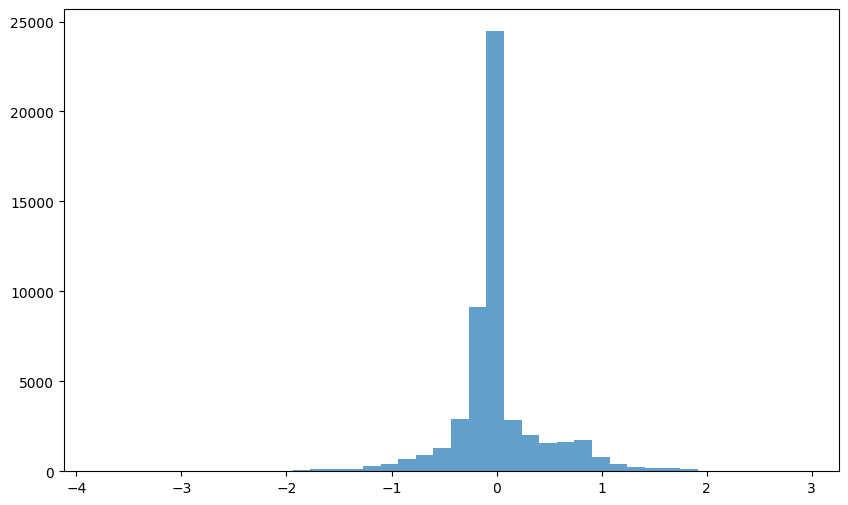

In [30]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

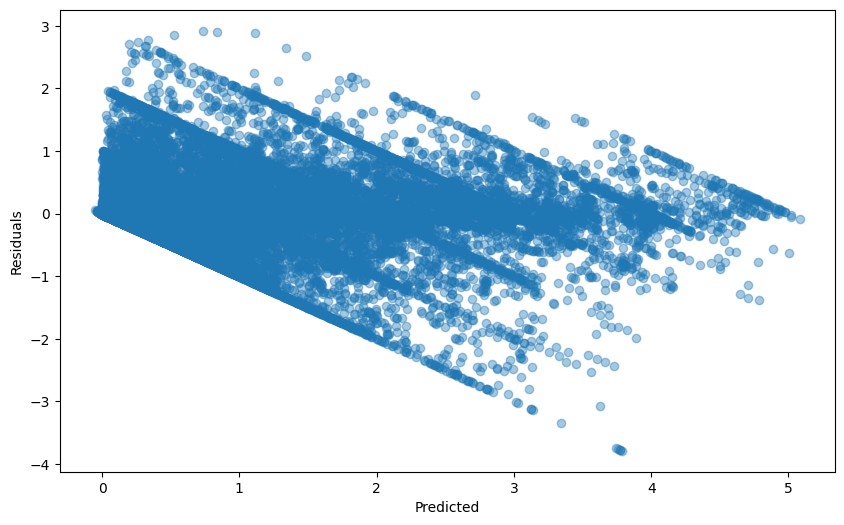

In [31]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

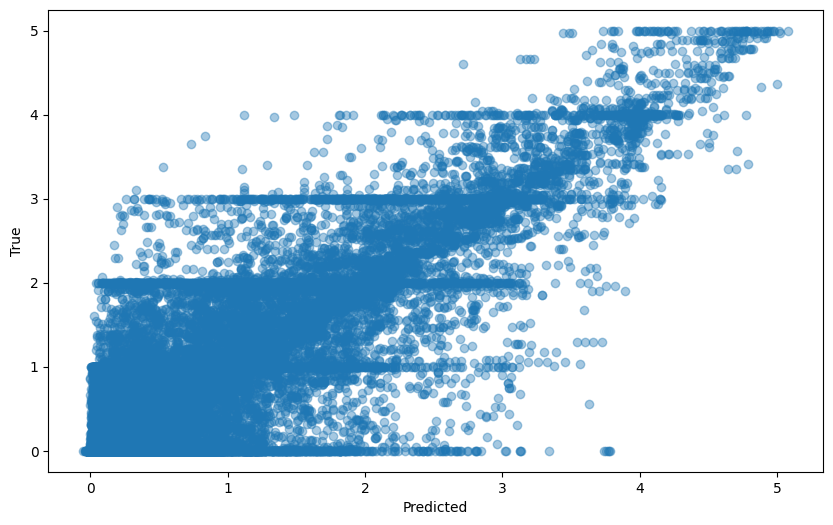

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")